In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="You are using `torch.load` with `weights_only=False`")
warnings.filterwarnings("ignore", category=UserWarning, message="The PyTorch API of nested tensors is in prototype stage and will change in the near future.")

%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0,"/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre")
            
import torch
torch.set_printoptions(precision=10)


import yaml
torch.set_float32_matmul_precision('high')
from pathlib import Path

from rdkit import Chem
from rdkit.Chem import Draw
# load model 
from datasets.dataset_utils import  fp_loader_configer

fp_loader_configer.select_version("Hash_Entropy")
fp_loader = fp_loader_configer.fp_loader

import numpy as np 
import random
seed=2
torch.cuda.manual_seed_all(seed) 
np.random.seed(seed)
random.seed(seed)



choosing Hash_Entropy_FP_loader


In [2]:
import pickle
with open(f'/root/gurusmart/MorganFP_prediction/inference_data/coconut_loutus_hyun_training/inference_metadata_latest_RDkit.pkl', 'rb') as file:
    smiles_and_names = pickle.load(file)
print(len(smiles_and_names))

526316


In [3]:
from inference.inference_utils import choose_model 


In [4]:
#### For infrastructure, 
#### run this:
# hparams, model  = choose_model_DB_specific_FP("C-NMR", include_test_loader = False)


hparams, model = choose_model("optional3", return_data_loader=False)
from datasets.optional_2d_folder_dataset import OptionalInputDataModule

datamodule = OptionalInputDataModule(dir="/workspace/SMILES_dataset", FP_choice=hparams["FP_choice"], input_src=["HSQC", "oneD_NMR"], fp_loader = fp_loader_configer.fp_loader, batch_size=1, parser_args=hparams)
datamodule.setup("test")
# loader_all_inputs, loader_HSQC_H_NMR, loader_HSQC_C_NMR, loader_only_hsqc, loader_only_1d, loader_only_H_NMR, loader_only_C_NMR = datamodule.test_dataloader()
test_dataloaders = datamodule.test_dataloader()


loading model from:  /root/gurusmart/MorganFP_prediction/reproduce_previous_works/entropy_on_hashes/flexible_models_jittering_flexible_MW_flexible_normal_hsqc/r0_r6_trial_3/checkpoints/epoch=67-step=46104.ckpt


Initialized SignCoordinateEncoder[784] with dims [365, 365, 54] and 2 positional encoders. 54 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args
finish entropy list
Hash_Entropy_FP_loader is setup, out_dim=16384, max_radius=6


In [5]:
max_radius = fp_loader.max_radius

rankingset_path = f"/root/gurusmart/MorganFP_prediction/inference_data/inference_rankingset_with_stable_sort/non_collision_FP_rankingset_max_radius_{max_radius}_dim_{hparams['out_dim']}_stacked_together/FP.pt"

rankingset_data = torch.load(rankingset_path)#.to("cuda")



/opt/conda/lib/python3.11/site-packages/torch/_utils.py:315: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  result = torch.sparse_compressed_tensor(


In [6]:
rankingset_data = rankingset_data.to(model.device)
len(rankingset_data), len(smiles_and_names)


(526316, 526316)

In [7]:
from torch.nn.functional import cosine_similarity
import tqdm
model.setup_ranker()
model.ranker.data = model.ranker.data.to(model.device)

loading /root/gurusmart/MorganFP_prediction/inference_data/inference_rankingset_with_stable_sort/non_collision_FP_rankingset_max_radius_6_dim_16384_stacked_together/FP.pt


In [12]:
import matplotlib.pyplot as plt
import numpy as np

plot_order =['eHSQC, H NMR, and C NMR',
 'eHSQC and C NMR',
 'Standard HSQC, H NMR, and C NMR',
 'Standard HSQC and C NMR',
 'eHSQC and H NMR',
 'eHSQC Only',
 'Standard HSQC and H NMR',
 'Standard HSQC only',
 'C NMR and H NMR',
 'DeepSAT -- eHSQC',
    'DeepSAT -- Standard HSQC',
 'C NMR Only',
 'H NMR Only']

from collections import defaultdict
def plot_topk_accuracy(mean_rank_records_list, max_k=25, title="Structure Dereplication (Similarity = 1.0)",
                       bbox_to_anchor=(0.5, 0.5),
                       ylabel = '% of correct dereplication (containing the ground truth compound)'):
    """
    Plot Top-K accuracy curves for different models, sorted by performance in the legend.

    Args:
        mean_rank_records (dict): Dictionary mapping model names to lists of ranks.
        max_k (int): Maximum K value to plot.
        title (str): Plot title.
    """

    plt.figure(figsize=(15, 10))

    # Define a list of distinct colors
    # These colors are chosen for better visual separation than default matplotlib colors.
    colors = [
        '#E6194B', "#4BDD5E", "#FFDD00", "#6F8AEE", '#F58231',
        '#911EB4', '#46F0F0', '#F032E6', 
        '#008080',  "#A7671F", "#0202FF", '#808080',  '#000000',
    ]

    def get_single_mdoel_performance(mean_rank_records):
        # Calculate Top-K accuracy for each model and store for sorting
        model_performance = {}
        for model_name, ranks in mean_rank_records.items():
            
            topk_accuracies = []
            for k in range(1, max_k + 1):
                correct_count = sum(1 for rank in ranks if rank < k)
                accuracy = (correct_count / len(ranks)) * 100
                topk_accuracies.append(accuracy)
            # Store the calculated accuracies and the model name
            model_performance[model_name] = topk_accuracies
            if model_name == "eHSQC, H NMR, and C NMR" or model_name == "eHSQC and C NMR":
                print(f"Model: {model_name}, Top-K Accuracies: {topk_accuracies[:5]}")
        return model_performance
    
    def average_dicts(json_list):
        avg_result = defaultdict(list)
        n = len(json_list)

        for key in json_list[0]:
            # Zip all corresponding lists under the same key
            for values in zip(*(j[key] for j in json_list)):
                avg_value = sum(values) / n
                avg_result[key].append(avg_value)

        return dict(avg_result)

    all_model_perfs = [get_single_mdoel_performance(record) for record in mean_rank_records_list]
    model_performance = average_dicts(all_model_perfs)
    # Sort models by their final accuracy (at max_k) in descending order
    # sorted_models = sorted(model_performance.items(), key=lambda item: item[1][-1], reverse=True)

    # for i, (model_name, topk_accuracies) in enumerate(sorted_models):
    for i, model_name in enumerate(plot_order):
        if model_name not in model_performance:
            # print(f"Warning: {model_name} not found in model_performance. Skipping.")
            continue
        topk_accuracies = model_performance[model_name]
        x_values = range(1, max_k + 1)
        plt.step(x_values, topk_accuracies,
                 label=model_name.replace("H NMR", "¹H NMR").replace("C NMR", "¹³C NMR").replace("only","").replace("Only",''),
                 color=colors[i % len(colors)],
                 linewidth=1.3,
                 where='post')

    # Customize the plot
    plt.xlabel('Top-K Retrieved Compounds', fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.title(title, fontsize=18)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=14,
               loc='center right',
                bbox_to_anchor=bbox_to_anchor
               )

    # Set axis limits
    plt.xlim(0, max_k)
    plt.ylim(0, 100)

    # Add more tick marks on x-axis
    plt.xticks(range(0, max_k + 1, 5), fontsize=15)
    plt.yticks(range(0, 101, 10), fontsize=15)

    plt.tight_layout()
    plt.show()

In [9]:
# Order: [loader_all_inputs, loader_HSQC_H_NMR, loader_HSQC_C_NMR, loader_only_hsqc, loader_only_1d, loader_only_H_NMR, loader_only_C_NMR]

old_loader_idx_to_name_mapping = {
    0: "All Inputs",
    1: "HSQC and H NMR",
    2: "HSQC and C NMR",
    3: "HSQC Only",
    4: "C NMR and H NMR",
    5: "H NMR Only",
    6: "C NMR Only",
    7: "Standard HSQC (Non-Multiplicity-Edited)",
}


loader_idx_to_name_mapping = {
    0: "eHSQC, H NMR, and C NMR",
    1: "eHSQC and H NMR",
    2: "eHSQC and C NMR",
    3: "eHSQC Only",
    4: "C NMR and H NMR",
    5: "H NMR Only",
    6: "C NMR Only",
    7: "Standard HSQC only",
    8: "Standard HSQC, H NMR, and C NMR",
    9: "Standard HSQC and H NMR",
    10: "Standard HSQC and C NMR",
    
    
}

In [10]:
old_name_to_loader_idx_mapping = {v: k for k, v in old_loader_idx_to_name_mapping.items()}

In [11]:
# import pickle

# save_dir= "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/inference/"

# with open(save_dir + "topk_with_mw.pkl", 'rb') as file:
#     pre_mean_rank_records = pickle.load(file)

# with open(save_dir + "topk_without_mw.pkl", 'rb') as file:
#     pre_mean_rank_records_no_MW = pickle.load(file)

# # # load 
# import pickle
# save_dir = "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/inference/"
# with open(save_dir + "topk_with_mw_11_input_types.pkl", 'rb') as file:
#     mean_rank_records = pickle.load(file)
# with open(save_dir + "topk_without_mw_11_input_types.pkl", 'rb') as file:
#     mean_rank_records_no_MW = pickle.load(file)


# mean_rank_records.keys()

In [12]:
from collections import defaultdict

## with MW
mean_rank_records = defaultdict(list)

for i in range(11):
    # if i<7:
    #     # loading from old records
    #     mean_rank_records[loader_idx_to_name_mapping[i]] = pre_mean_rank_records[old_loader_idx_to_name_mapping[i]]
    #     continue
    loader_idx = i
    if i == 7: # Standard HSQC only
        loader_idx = 3
    if i == 8: # Standard HSQC, H NMR, and C NMR
        loader_idx = 0
    if i == 9: # Standard HSQC and H NMR
        loader_idx = 1
    if i == 10: # Standard HSQC and C NMR
        loader_idx = 2
        
    for idx, batch in tqdm.tqdm(enumerate(test_dataloaders[loader_idx])):
        batch[0] = batch[0].to(model.device)
        batch[1] = batch[1].to(model.device)
        batch[2] = batch[2].to(model.device)
        
        if i >= 7:
            # last column all zeros
            batch[0][:, :, -1] = 0
        with torch.no_grad():
            result =  model.test_step(batch, 0, dataloader_idx=loader_idx)
        mean_rank_records[loader_idx_to_name_mapping[i]].append(result['mean_rank'])

41it [00:01, 42.72it/s]

4056it [01:30, 44.95it/s]
4056it [01:27, 46.38it/s]
4056it [01:27, 46.48it/s]
4056it [01:26, 47.09it/s]
4056it [01:25, 47.19it/s]
4056it [01:25, 47.26it/s]
4056it [01:26, 46.72it/s]
4056it [01:26, 46.64it/s]
4056it [01:28, 45.76it/s]
4056it [01:27, 46.31it/s]
4056it [01:27, 46.37it/s]


In [13]:
# plot_topk_accuracy(mean_rank_records, title="", 
#                    max_k=25,
#                    bbox_to_anchor=(1,0.41)) #Structure Dereplication (using molecular weight)

In [14]:
# for k,v in mean_rank_records.items():
#     print(k, np.mean(v))

In [15]:

        
        
        
        

## without  MW
mean_rank_records_no_MW = defaultdict(list)
for i in range(11):
    
    # if i<7:
    #     # loading from old records
    #     mean_rank_records_no_MW[loader_idx_to_name_mapping[i]] = pre_mean_rank_records_no_MW[old_loader_idx_to_name_mapping[i]]
    #     continue
    loader_idx = i
    if i == 7: # Standard HSQC only
        loader_idx = 3
    if i == 8: # Standard HSQC, H NMR, and C NMR
        loader_idx = 0
    if i == 9: # Standard HSQC and H NMR
        loader_idx = 1
    if i == 10: # Standard HSQC and C pNMR
        loader_idx = 2
        
    for idx, batch in tqdm.tqdm(enumerate(test_dataloaders[loader_idx])):
        batch[0] = batch[0].to(model.device)
        batch[1] = batch[1].to(model.device)
        batch[2] = batch[2].to(model.device)
        
        # remove mw
        batch[0] = batch[0][:, :-1]
        # remove mw
        batch[2] = batch[2][:, :-1]
        
        if i >= 7:
            # last column all zeros
            batch[0][:, :, -1] = 0
        with torch.no_grad():
            result =  model.test_step(batch, 0, dataloader_idx=loader_idx)
        mean_rank_records_no_MW[loader_idx_to_name_mapping[i]].append(result['mean_rank'])        


45it [00:00, 46.16it/s]

4056it [01:27, 46.34it/s]
4056it [01:27, 46.34it/s]
4056it [01:27, 46.22it/s]
4056it [01:26, 46.93it/s]
4056it [01:26, 46.74it/s]
4056it [01:25, 47.18it/s]
4056it [01:26, 47.15it/s]
4056it [01:26, 47.10it/s]
4056it [01:27, 46.44it/s]
4056it [01:27, 46.44it/s]
4056it [01:27, 46.37it/s]


In [16]:
for k,v in mean_rank_records_no_MW.items():
    print(k, np.mean(v))

eHSQC, H NMR, and C NMR 205.35650887573965
eHSQC and H NMR 438.4886587771203
eHSQC and C NMR 166.87475345167653
eHSQC Only 367.50024654832345
C NMR and H NMR 1013.7088264299803
H NMR Only 14359.53057199211
C NMR Only 2631.4546351084814
Standard HSQC only 1030.2046351084812
Standard HSQC, H NMR, and C NMR 378.7307692307692
Standard HSQC and H NMR 758.8382642998027
Standard HSQC and C NMR 505.08308678500987


In [17]:
# # cobining DeepSAT result into mean_rank_records_no_MW
# # 
# import pickle
# import tqdm
# from collections import defaultdict
# mean_rank_records_no_MW = defaultdict(list)
# shared_testset_pkl = "shared_testset_path_for_deepsat_hsqc_available" 
# with open(f"/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/compare_with_deepsat/{shared_testset_pkl}.pkl", "rb") as f:
#     shared_testset_path = pickle.load(f)
    
    
# deepsat_infer_results_save_path = "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/compare_with_deepsat/deepsat_infer_entire_retrieval_set.pkl"
# with open(deepsat_infer_results_save_path, "rb") as f:
#     deepsat_infer_results = pickle.load(f)
    
# mean_rank_records_no_MW.update({"DeepSAT -- eHSQC": []})  
# for csv_f, ground_smiles, ground_mw, np_class in tqdm.tqdm(shared_testset_path):
#     result = deepsat_infer_results[(csv_f, ground_smiles, ground_mw, np_class)]
   
#     for i, (cos_scores,filtered_mws, filtered_smiles ) in enumerate(result):
        
#         if ( ground_smiles == filtered_smiles):
#             mean_rank_records_no_MW["DeepSAT -- eHSQC"].append(i)
#             break
#     else:
#         mean_rank_records_no_MW["DeepSAT -- eHSQC"].append(50)
        
        
        
# deepsat_infer_results_save_path = "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/compare_with_deepsat/deepsat_infer_entire_retrieval_set_standard_HSQC.pkl"
# with open(deepsat_infer_results_save_path, "rb") as f:
#     deepsat_infer_results = pickle.load(f)
    
# mean_rank_records_no_MW.update({"DeepSAT -- Standard HSQC": []})  
# for csv_f, ground_smiles, ground_mw, np_class in tqdm.tqdm(shared_testset_path):
#     result = deepsat_infer_results[(csv_f, ground_smiles, ground_mw, np_class)]
   
#     for i, (cos_scores,filtered_mws, filtered_smiles ) in enumerate(result):
        
#         if ( ground_smiles == filtered_smiles):
#             mean_rank_records_no_MW["DeepSAT -- Standard HSQC"].append(i)
#             break
#     else:
#         mean_rank_records_no_MW["DeepSAT -- Standard HSQC"].append(50)

In [18]:
# import pickle
# save_dir_ranking = "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/compare_with_deepsat/deepsat_inference_results/ranking_result/"

# load_path = save_dir_ranking + "ranking.pkl"

# with open(load_path, 'rb') as file:
#     loaded = pickle.load(file)
# mean_rank_records_no_MW["HSQC, by DeepSAT"] = loaded



In [19]:
# mean_rank_records_no_MW.pop("DeepSAT -- eHSQC")
# mean_rank_records_no_MW.pop("DeepSAT -- Standard HSQC")

In [20]:
# plot_topk_accuracy(mean_rank_records_no_MW, 
#                    title="",
#                    max_k=25,
#                    bbox_to_anchor=(1,0.41)) #Structure Dereplication (not using molecular weight)


In [21]:

save_dir= "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/inference/"

with open(save_dir + "topk_with_mw_11_input_types_3.pkl", 'wb') as file:
    pickle.dump(mean_rank_records, file)
with open(save_dir + "topk_without_mw_11_input_types_3.pkl", 'wb') as file:
    pickle.dump(mean_rank_records_no_MW, file)



to visualize topk with and without MW

In [17]:
# # load 
import pickle
save_dir = "/root/gurusmart/MorganFP_prediction/reproduce_previous_works/Spectre/inference/"
with open(save_dir + "topk_with_mw_11_input_types.pkl", 'rb') as file:
    mean_rank_records = pickle.load(file)
with open(save_dir + "topk_without_mw_11_input_types.pkl", 'rb') as file:
    mean_rank_records_no_MW = pickle.load(file)
    
mean_rank_records_no_MW.pop("DeepSAT -- eHSQC")
mean_rank_records_no_MW.pop("DeepSAT -- Standard HSQC")

with open(save_dir + "topk_with_mw_11_input_types_2.pkl", 'rb') as file:
    mean_rank_records_2 = pickle.load(file)
with open(save_dir + "topk_without_mw_11_input_types_2.pkl", 'rb') as file:
    mean_rank_records_no_MW_2 = pickle.load(file)
    
with open(save_dir + "topk_with_mw_11_input_types_3.pkl", 'rb') as file:
    mean_rank_records_3 = pickle.load(file)
with open(save_dir + "topk_without_mw_11_input_types_3.pkl", 'rb') as file:
    mean_rank_records_no_MW_3 = pickle.load(file) 

In [ ]:
# from collections import defaultdict

# def average_json_list(json_list):
#     avg_result = defaultdict(list)
#     n = len(json_list)

#     for key in json_list[0]:
#         # Zip all corresponding lists under the same key
#         for values in zip(*(j[key] for j in json_list)):
#             avg_value = sum(values) / n
#             avg_result[key].append(avg_value)

#     return dict(avg_result)

# data_list = [mean_rank_records, mean_rank_records_2,  mean_rank_records_3]
# mean_rank_records = average_json_list(data_list)


Model: eHSQC, H NMR, and C NMR, Top-K Accuracies: [51.3560157790927, 68.07199211045365, 75.51775147928994, 79.93096646942801, 82.56903353057199]
Model: eHSQC and C NMR, Top-K Accuracies: [51.79980276134122, 68.24457593688363, 75.64102564102564, 79.65976331360946, 82.3224852071006]
Model: eHSQC, H NMR, and C NMR, Top-K Accuracies: [51.3560157790927, 67.9733727810651, 75.88757396449705, 79.88165680473372, 82.76627218934911]
Model: eHSQC and C NMR, Top-K Accuracies: [50.93688362919132, 67.85009861932939, 75.66568047337277, 80.02958579881657, 82.86489151873766]
Model: eHSQC, H NMR, and C NMR, Top-K Accuracies: [54.88165680473372, 70.3895463510848, 77.85996055226825, 82.34714003944774, 84.91124260355029]
Model: eHSQC and C NMR, Top-K Accuracies: [54.11735700197239, 69.99506903353058, 77.7613412228797, 82.0266272189349, 84.51676528599606]


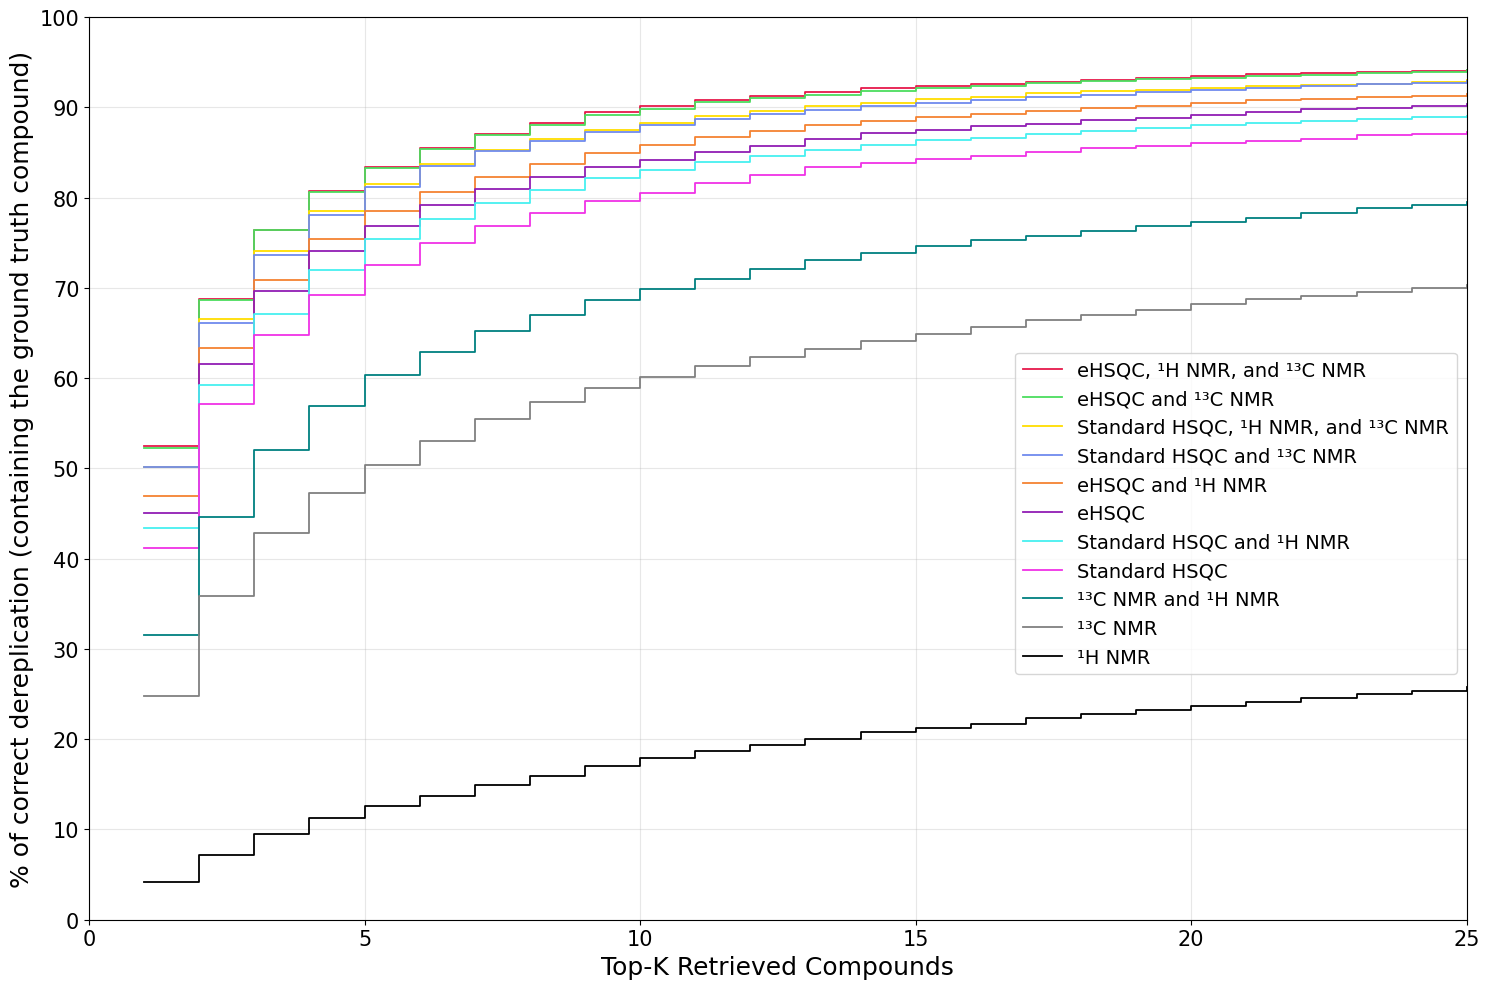

In [15]:
plot_topk_accuracy([mean_rank_records, mean_rank_records_2,  mean_rank_records_3], title="", 
                   max_k=25,
                   bbox_to_anchor=(1,0.45)) #Structure Dereplication (using molecular weight)

In [ ]:
# data_list = [mean_rank_records_no_MW, mean_rank_records_no_MW_2,  mean_rank_records_no_MW_3]
# mean_rank_records_no_MW = average_json_list(data_list)

Model: eHSQC, H NMR, and C NMR, Top-K Accuracies: [50.641025641025635, 67.7268244575937, 74.90138067061145, 79.75838264299803, 82.39644970414201]
Model: eHSQC and C NMR, Top-K Accuracies: [51.553254437869825, 67.94871794871796, 75.14792899408283, 79.16666666666666, 82.05128205128204]
Model: eHSQC, H NMR, and C NMR, Top-K Accuracies: [51.134122287968445, 67.40631163708086, 75.54240631163708, 79.70907297830375, 82.54437869822485]
Model: eHSQC and C NMR, Top-K Accuracies: [50.96153846153846, 67.75147928994083, 75.4930966469428, 80.05424063116371, 82.74161735700197]
Model: eHSQC, H NMR, and C NMR, Top-K Accuracies: [54.38856015779092, 70.34023668639054, 77.66272189349112, 82.00197238658777, 84.61538461538461]
Model: eHSQC and C NMR, Top-K Accuracies: [53.77218934911243, 70.09368836291914, 77.56410256410257, 81.87869822485207, 84.56607495069034]


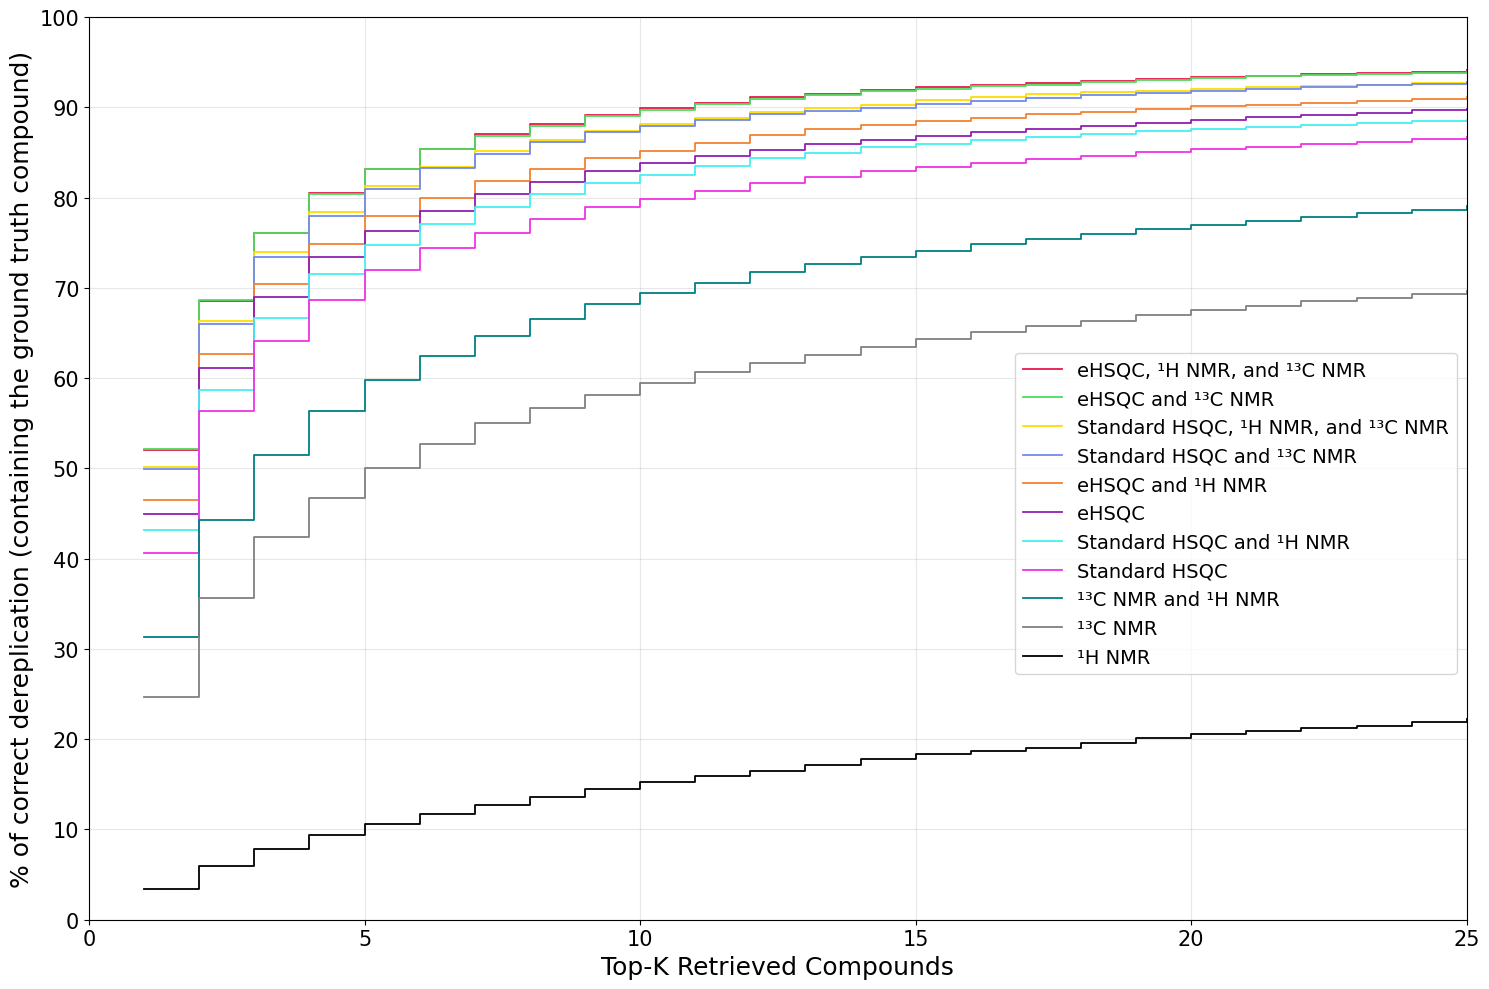

In [16]:
plot_topk_accuracy([mean_rank_records_no_MW, mean_rank_records_no_MW_2,  mean_rank_records_no_MW_3], 
                   title="",
                   max_k=25,
                   bbox_to_anchor=(1,0.45)) #Structure Dereplication (not using molecular weight)


In [34]:
import matplotlib.pyplot as plt
import numpy as np

plot_order =['eHSQC, H NMR, and C NMR',
 'eHSQC and C NMR',
 'Standard HSQC, H NMR, and C NMR',
 'Standard HSQC and C NMR',
 'eHSQC and H NMR',
 'eHSQC Only',
 'Standard HSQC and H NMR',
 'Standard HSQC only',
 'C NMR and H NMR',
 'DeepSAT -- eHSQC',
    'DeepSAT -- Standard HSQC',
 'C NMR Only',
 'H NMR Only']

from collections import defaultdict
def show_ranks(mean_rank_records_list, max_k=25, title="Structure Dereplication (Similarity = 1.0)",
                       bbox_to_anchor=(0.5, 0.5),
                       ylabel = '% of correct dereplication (containing the ground truth compound)'):
    """
    Plot Top-K accuracy curves for different models, sorted by performance in the legend.

    Args:
        mean_rank_records (dict): Dictionary mapping model names to lists of ranks.
        max_k (int): Maximum K value to plot.
        title (str): Plot title.
    """

   

    def get_single_mdoel_performance(mean_rank_records):
        # Calculate Top-K accuracy for each model and store for sorting
        model_performance = {}
        for model_name, ranks in mean_rank_records.items():
            
            topk_accuracies = []
            for k in range(1, max_k + 1):
                correct_count = sum(1 for rank in ranks if rank < k)
                accuracy = (correct_count / len(ranks)) * 100
                topk_accuracies.append(accuracy)
            # Store the calculated accuracies and the model name
            model_performance[model_name] = topk_accuracies
 
        return model_performance
    
    def average_dicts(json_list):
        avg_result = defaultdict(list)
        n = len(json_list)

        for key in json_list[0]:
            # Zip all corresponding lists under the same key
            for it, values in enumerate(zip(*(j[key] for j in json_list))):
                if it in  [0, 4, 9]:
                    print(f'rank = {it+1}')
                    print(f"key: {key}", end="  ")
                    
                    # print(values)
                    print(f"mean: {np.mean(values):.2f}, std: {np.std(values):.2f}")
                    avg_value = sum(values) / n
                    avg_result[key].append(avg_value)

        return dict(avg_result)

    all_model_perfs = [get_single_mdoel_performance(record) for record in mean_rank_records_list]
    model_performance = average_dicts(all_model_perfs)

      

In [35]:
show_ranks([mean_rank_records_no_MW, mean_rank_records_no_MW_2,  mean_rank_records_no_MW_3])

rank = 1
key: eHSQC, H NMR, and C NMR  mean: 52.05, std: 1.66
rank = 5
key: eHSQC, H NMR, and C NMR  mean: 83.19, std: 1.01
rank = 10
key: eHSQC, H NMR, and C NMR  mean: 89.92, std: 0.74
rank = 1
key: eHSQC and H NMR  mean: 46.55, std: 1.86
rank = 5
key: eHSQC and H NMR  mean: 77.93, std: 1.28
rank = 10
key: eHSQC and H NMR  mean: 85.15, std: 0.86
rank = 1
key: eHSQC and C NMR  mean: 52.10, std: 1.21
rank = 5
key: eHSQC and C NMR  mean: 83.12, std: 1.06
rank = 10
key: eHSQC and C NMR  mean: 89.70, std: 0.56
rank = 1
key: eHSQC Only  mean: 44.99, std: 1.51
rank = 5
key: eHSQC Only  mean: 76.24, std: 1.32
rank = 10
key: eHSQC Only  mean: 83.80, std: 0.82
rank = 1
key: C NMR and H NMR  mean: 31.27, std: 1.42
rank = 5
key: C NMR and H NMR  mean: 59.83, std: 1.52
rank = 10
key: C NMR and H NMR  mean: 69.41, std: 1.08
rank = 1
key: H NMR Only  mean: 3.45, std: 0.04
rank = 5
key: H NMR Only  mean: 10.63, std: 0.42
rank = 10
key: H NMR Only  mean: 15.29, std: 0.58
rank = 1
key: C NMR Only  mea

In [36]:
show_ranks([mean_rank_records, mean_rank_records_2,  mean_rank_records_3])

rank = 1
key: eHSQC, H NMR, and C NMR  mean: 52.53, std: 1.66
rank = 5
key: eHSQC, H NMR, and C NMR  mean: 83.42, std: 1.06
rank = 10
key: eHSQC, H NMR, and C NMR  mean: 90.18, std: 0.73
rank = 1
key: eHSQC and H NMR  mean: 46.89, std: 1.85
rank = 5
key: eHSQC and H NMR  mean: 78.48, std: 1.03
rank = 10
key: eHSQC and H NMR  mean: 85.80, std: 0.68
rank = 1
key: eHSQC and C NMR  mean: 52.28, std: 1.34
rank = 5
key: eHSQC and C NMR  mean: 83.23, std: 0.93
rank = 10
key: eHSQC and C NMR  mean: 89.86, std: 0.58
rank = 1
key: eHSQC Only  mean: 45.09, std: 1.52
rank = 5
key: eHSQC Only  mean: 76.83, std: 1.20
rank = 10
key: eHSQC Only  mean: 84.16, std: 0.81
rank = 1
key: C NMR and H NMR  mean: 31.51, std: 1.21
rank = 5
key: C NMR and H NMR  mean: 60.29, std: 1.53
rank = 10
key: C NMR and H NMR  mean: 69.85, std: 0.96
rank = 1
key: H NMR Only  mean: 4.14, std: 0.29
rank = 5
key: H NMR Only  mean: 12.63, std: 0.72
rank = 10
key: H NMR Only  mean: 17.91, std: 1.18
rank = 1
key: C NMR Only  mea